<a href="https://colab.research.google.com/github/Jyok1m/cnn-image-project/blob/main/m3_JJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow Model 3

## Import dataset

- For this model, we decide to import the dataset via KaggleHub.
- The model will be saved locally.
- We then print and save the path in a dotenv file for data protection.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [3]:
DATASET_URI="/kaggle/input/animals10/raw-img"

In [ ]:
# from dotenv import dotenv_values

# # Retrieve dotenv config
# config = dotenv_values(".env")

# # Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [4]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras

### Data conversion

In [5]:
# Define the parameters.

random.seed(10)
batch_size = 64 # Batch size increase to 64
img_height = 224
img_width = 224
seed = random.randint(1, 200)

# We then import the dataset from directory and store the data in train and test.
# We follow a rule of 90% for training and 10% for testing.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [6]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (64, 224, 224, 3)
Shape of the training set labels => (64,)
Shape of the testing set images => (64, 224, 224, 3)
Shape of the testing set labels => (64,)


#### Pre-visualization

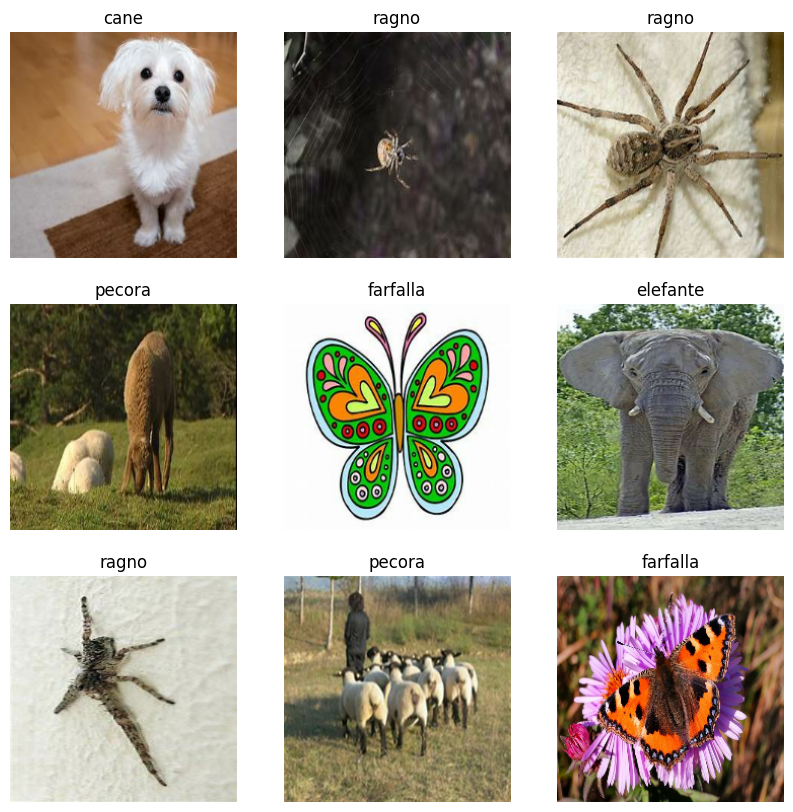

In [9]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))

class_names = train_ds.class_names
num_classes = len(class_names)

for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


In [11]:
# Model creation with regularization and batch normalization
model_3 = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Rescaling(1./255),

    keras.layers.RandomFlip("horizontal_and_vertical"), # Add random flip and rotation
    keras.layers.RandomRotation(0.2),

    keras.layers.RandomFlip("horizontal_and_vertical"), # Add random flip and rotation
    keras.layers.RandomRotation(0.2),

    keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(num_classes, activation="softmax")
])

# Model compilation
model_3.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, cooldown=5, mode='auto')

# Model training
model_3_hist = model_3.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50, # Augmentation du nb epochs w/ early stopping to prevent to much loss
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 162s 410ms/step - accuracy: 0.1732 - loss: 19.3919 - val_accuracy: 0.1777 - val_loss: 7.6603 - learning_rate: 0.0010
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accuracy: 0.2566 - loss: 5.0399 - val_accuracy: 0.2637 - val_loss: 3.7884 - learning_rate: 0.0010
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accuracy: 0.3070 - loss: 3.3480 - val_accuracy: 0.3145 - val_loss: 2.9885 - learning_rate: 0.0010
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accuracy: 0.3378 - loss: 2.8885 - val_accuracy: 0.3202 - val_loss: 3.5596 - learning_rate: 0.0010
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accuracy: 0.3529 - loss: 2.8601 - val_accuracy: 0.2831 - val_loss: 3.2933 - learning_rate: 0.0010
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accuracy: 0.3730 - loss: 2.7408 - val_accuracy: 0.2549 - val_loss: 3.0658 - learning_rate: 0.0010
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 149s 404ms/step - accur

In [12]:
model_3.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m3_JJ.keras")

In [13]:
model_4 = keras.models.load_model("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m3_JJ.keras")

In [14]:
model_4.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, cooldown=5, mode='auto')

# Model training
model_4_hist = model_4.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50, # Augmentation du nb epochs w/ early stopping to prevent to much loss
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 153s 404ms/step - accuracy: 0.4378 - loss: 3.7802 - val_accuracy: 0.4131 - val_loss: 3.7749 - learning_rate: 0.0010
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.4828 - loss: 3.6597 - val_accuracy: 0.4505 - val_loss: 3.7873 - learning_rate: 0.0010
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 401ms/step - accuracy: 0.5140 - loss: 3.6565 - val_accuracy: 0.4070 - val_loss: 3.9124 - learning_rate: 0.0010
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 401ms/step - accuracy: 0.5256 - loss: 3.6426 - val_accuracy: 0.4062 - val_loss: 4.3567 - learning_rate: 0.0010
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.5916 - loss: 2.9646 - val_accuracy: 0.5533 - val_loss: 2.4302 - learning_rate: 2.0000e-04
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.6445 - loss: 2.0703 - val_accuracy: 0.5629 - val_loss: 2.2632 - learning_rate: 2.0000e-04
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 401ms/step 

In [15]:
model_4.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m4_JJ.keras")

In [16]:
model_5 = keras.models.load_model("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m4_JJ.keras")

In [18]:
# Compile the model
model_5.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    cooldown=3,
    mode='max',  # Since accuracy is being monitored
    min_delta=0.005  # Lower min_delta to be more sensitive
)

# Model training
model_5_hist = model_5.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,  # Increased number of epochs with early stopping
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 153s 403ms/step - accuracy: 0.5729 - loss: 3.4048 - val_accuracy: 0.3477 - val_loss: 4.7364 - learning_rate: 0.0010
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.5820 - loss: 3.4722 - val_accuracy: 0.3978 - val_loss: 4.1697 - learning_rate: 0.0010
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.5970 - loss: 3.3562 - val_accuracy: 0.4295 - val_loss: 3.9124 - learning_rate: 0.0010
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.6126 - loss: 3.1820 - val_accuracy: 0.4631 - val_loss: 3.6654 - learning_rate: 0.0010
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 401ms/step - accuracy: 0.6127 - loss: 3.1171 - val_accuracy: 0.3229 - val_loss: 4.4892 - learning_rate: 0.0010
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 401ms/step - accuracy: 0.6172 - loss: 3.0892 - val_accuracy: 0.2621 - val_loss: 5.0176 - learning_rate: 0.0010
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accura

In [27]:
model_5.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m5_JJ.keras")

## Model evaluation

### Retrieve the keys

In [19]:
print(model_5_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


### Print the graph

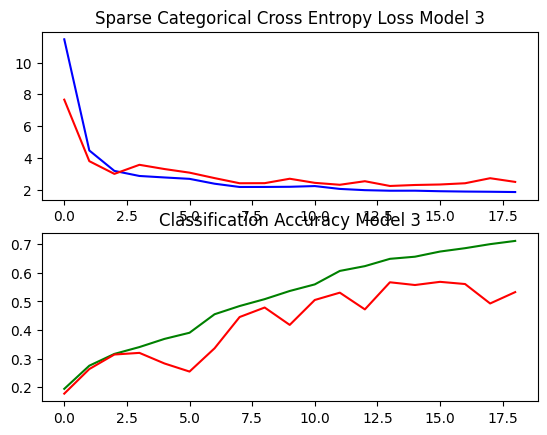

In [21]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss Model 3')
plt.plot(model_3_hist.history['loss'], color='blue', label='train')
plt.plot(model_3_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy Model 3')
plt.plot(model_3_hist.history['accuracy'], color='green', label='train')
plt.plot(model_3_hist.history['val_accuracy'], color='red', label='val')

plt.show()

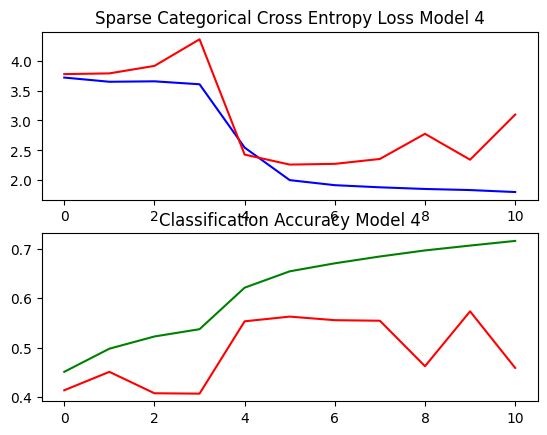

In [22]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss Model 4')
plt.plot(model_4_hist.history['loss'], color='blue', label='train')
plt.plot(model_4_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy Model 4')
plt.plot(model_4_hist.history['accuracy'], color='green', label='train')
plt.plot(model_4_hist.history['val_accuracy'], color='red', label='val')

plt.show()

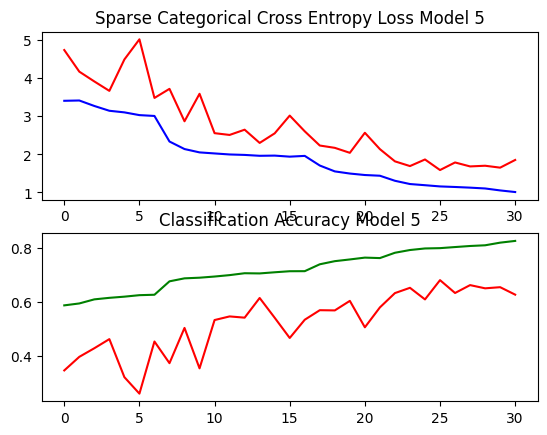

In [20]:


plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss Model 5')
plt.plot(model_5_hist.history['loss'], color='blue', label='train')
plt.plot(model_5_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy Model 5')
plt.plot(model_5_hist.history['accuracy'], color='green', label='train')
plt.plot(model_5_hist.history['val_accuracy'], color='red', label='val')

plt.show()

### Evaluate the model

In [23]:
test_loss, test_acc = model_3.evaluate(test_ds, verbose=1)
print('Test loss Model 3 => ', test_loss)
print('Test accuracy Model 3 => ', test_acc)

test_loss, test_acc = model_4.evaluate(test_ds, verbose=1)
print('Test loss Model 4 => ', test_loss)
print('Test accuracy Model 4 => ', test_acc)

test_loss, test_acc = model_5.evaluate(test_ds, verbose=1)
print('Test loss Model 5 => ', test_loss)
print('Test accuracy Model 5 => ', test_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5612 - loss: 2.2381
Test loss Model 3 =>  2.2271225452423096
Test accuracy Model 3 =>  0.5670615434646606
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5713 - loss: 2.2317
Test loss Model 4 =>  2.2632319927215576
Test accuracy Model 4 =>  0.5628582239151001
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6793 - loss: 1.5657
Test loss Model 5 =>  1.588631510734558
Test accuracy Model 5 =>  0.6805502772331238


### Print confusion matrix

In [25]:
import numpy as np
predictions = model_3.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
(2617, 10)
[[ 52  86  45  69 107  15  14  32  55  26]
 [ 29  33  41  39  53   7   3  22  28  11]
 [ 16  25  14  14  27   8   3   6  26  10]
 [ 21  40  22  26  44   6   3  12  27  12]
 [ 30  52  40  36  67   9   3  17  35  13]
 [ 14  26  18  20  19   1   3  10  23   8]
 [ 20  33  24  16  24   4   2  12  20   7]
 [ 21  32  23  26  49   5   2  12  25  10]
 [ 42  70  41  55  84   6   6  36  85  35]
 [ 26  33  34  31  38   8   4  15  22   6]]


In [24]:
import numpy as np
predictions = model_4.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
(2617, 10)
[[ 59  57 111  76  64  11   9  19  60  35]
 [ 27  26  55  48  37   8   4   9  36  16]
 [ 12  21  32  22  19   1   2   4  23  13]
 [ 25  21  35  33  34   8   4  12  22  19]
 [ 31  39  54  51  39  13   1  14  36  24]
 [ 16  27  32  22  14   2   1   3  16   9]
 [ 17  23  29  21  21   6   4   7  26   8]
 [ 30  20  31  34  34   4   1  11  26  14]
 [ 49  56 102  58  58  15   4  12  67  39]
 [ 18  26  45  38  25   8   3   4  35  15]]


In [26]:
import numpy as np
predictions = model_5.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
(2617, 10)
[[70 80 65 55 57 29 15 26 74 30]
 [34 38 38 32 32 11  7 22 35 17]
 [30 22 24 11 14 10  2  8 21  7]
 [32 23 28 29 25 11  6 16 33 10]
 [57 40 37 35 41 18  7 12 40 15]
 [15 15 13 26 24  6  2  8 24  9]
 [21 16 26 20 19 10  9 10 23  8]
 [27 28 27 30 13 11  7 16 33 13]
 [63 60 57 57 45 20 13 29 83 33]
 [33 27 22 34 23 12  9 12 32 13]]


### Test model 5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This image has a 73.30% chance of being a sheep image.


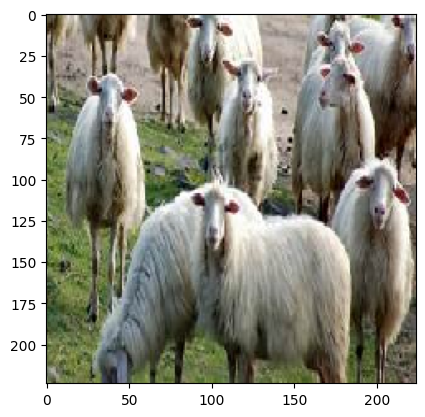

In [50]:
img = keras.utils.load_img("/kaggle/input/animals10/raw-img/pecora/OIP--7uwd4vM_LY8t9PB70SYvQHaEV.jpeg", target_size=(img_height, img_width))

plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model_5.predict(img_array)
highest = max(predictions[0])
highest_index = np.argmax(predictions[0])

best_label = class_names[highest_index]

translation_dict = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "dog": "cane",
    "cavallo": "horse",
    "elephant" : "elefante",
    "butterfly": "farfalla",
    "chicken": "gallina",
    "cat": "gatto",
    "cow": "mucca",
    "spider": "ragno",
    "squirrel": "scoiattolo"
    }

best_label = translation_dict[best_label]

print(f"This image has a {100 * (highest):.2f}% chance of being a {best_label} image.")